<a href="https://colab.research.google.com/github/scgupta/yearn2learn/blob/master/ml/pandas/pandas_apply_fn_on_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to efficently apply a function to Pandas Dataframe rows

## Setup

Install needed libs and import modules.

In [ ]:
!pip install faker line_profiler perfplot

     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 163kB 9.6MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 


In [ ]:
%load_ext line_profiler

In [ ]:
import numpy as np
import pandas as pd
import datetime
import perfplot

from faker import Faker

## Test Data

In real life, this data would be read from a CSV file or a data store. But for this tutorial, generating test data to keep it simple.

In [ ]:
def generate_test_data(size: int, days: int = 30):
  fake = Faker()
  Faker.seed(42)

  PRIORITIES = {
    0: 'HIGH',
    1: 'MEDIUM',
    2: 'LOW'
  }

  return pd.DataFrame({
    'task_name': [
      f'Task {i + 1}'
      for i in range(size)
    ],
    'due_date': [
      fake.date_between(start_date='today', end_date=f'+{days}d')
      for _ in range(size)
    ],
    'priority': [
      PRIORITIES[fake.pyint(min_value=0, max_value=(len(PRIORITIES) - 1))]
      for i in range(size)
    ]
  })


In [ ]:
# Try generate_test_data
tmp_df = generate_test_data(10, 5)
tmp_df.info()
tmp_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   task_name  10 non-null     object
 1   due_date   10 non-null     object
 2   priority   10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


,task_name,due_date,priority
0,Task 1,2020-10-07,LOW
1,Task 2,2020-10-04,LOW
2,Task 3,2020-10-04,LOW
3,Task 4,2020-10-08,HIGH
4,Task 5,2020-10-05,LOW
5,Task 6,2020-10-05,MEDIUM
6,Task 7,2020-10-05,HIGH
7,Task 8,2020-10-04,HIGH
8,Task 9,2020-10-08,HIGH
9,Task 10,2020-10-04,HIGH


In [ ]:
tmp_df['task_name'].loc[0]

'Task 1'

In [ ]:
tmp_df['due_date'].loc[0]
# pd.to_datetime(tmp_df['due_date']).dt.date.loc[0]

datetime.date(2020, 10, 7)

In [ ]:
tmp_df['priority'].loc[0]

'LOW'

### Generate Test Dataset

In [ ]:
# Generate a million rows. Use sample from it to create various size data sets
# Will take some time as Faker will be called sequencially.
test_data_set = generate_test_data(1000000, 90)

In [ ]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2020-12-05,HIGH
1,Task 2,2020-10-14,LOW
2,Task 3,2020-10-06,LOW
3,Task 4,2020-12-14,MEDIUM
4,Task 5,2020-10-30,HIGH


In [ ]:
def test_data_sample(size: int):
  return test_data_set.sample(n=size).copy().reset_index(drop=True)

In [ ]:
# Test sample of size 10
test_data_sample(10).head(5)

,task_name,due_date,priority
0,Task 642300,2020-12-29,HIGH
1,Task 312026,2020-10-12,LOW
2,Task 255858,2020-10-15,MEDIUM
3,Task 598030,2020-11-04,LOW
4,Task 643474,2020-10-12,HIGH


In [ ]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2020-12-05,HIGH
1,Task 2,2020-10-14,LOW
2,Task 3,2020-10-06,LOW
3,Task 4,2020-12-14,MEDIUM
4,Task 5,2020-10-30,HIGH


## Optimize DataFrame Storage

Compacting the data not only saves space, but also speeds up the processing. Two common opportunities are:

- Converting timestamp strings or datetime to [datetime64](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- Converting strings of enum types to [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) data type

For fair comparision, compression test data to max extent possible.

In [ ]:
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   task_name  1000000 non-null  object
 1   due_date   1000000 non-null  object
 2   priority   1000000 non-null  object
dtypes: object(3)
memory usage: 22.9+ MB


In [ ]:
priority_dtype = pd.api.types.CategoricalDtype(
  categories=['LOW', 'MEDIUM', 'HIGH'],
  ordered=True
)

In [ ]:
priority_map = dict(enumerate(pd.Series(['']).astype(priority_dtype).cat.categories))
priority_map

{0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

In [ ]:
test_data_set['priority'] = test_data_set['priority'].astype(priority_dtype)
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype   
---  ------     --------------    -----   
 0   task_name  1000000 non-null  object  
 1   due_date   1000000 non-null  object  
 2   priority   1000000 non-null  category
dtypes: category(1), object(2)
memory usage: 16.2+ MB


In [ ]:
test_data_set['priority'].loc[0]

'HIGH'

Using category for priority reduced the memory usage by ~30%.

## Optimize DataFrame Processing Time

### The Eisenhower Method

Decide about action needed using [Eisenhower method](https://en.wikipedia.org/wiki/Time_management#The_Eisenhower_Method):

| Important | Urgent    | Binary | Int | Action   |
| --------- | --------- | :----: | :-: | -------- |
| True (1)  | True (1)  |   11   |  3  | DO       |
| True (1)  | False (0) |   10   |  2  | SCHEDULE |
| False (0) | True (1)  |   01   |  1  | DELEGATE |
| False (0) | False (0) |   00   |  0  | DELETE   |

In [ ]:
action_dtype = pd.api.types.CategoricalDtype(
  categories=['DELETE', 'DELEGATE', 'SCHEDULE', 'DO'],
  ordered=True
)

In [ ]:
action_map = dict(enumerate(pd.Series(['']).astype(action_dtype).cat.categories))
action_map

{0: 'DELETE', 1: 'DELEGATE', 2: 'SCHEDULE', 3: 'DO'}

In [ ]:
def eisenhower_action(is_important: bool, is_urgent: bool) -> int:
  return 2 * is_important + is_urgent

def eisenhower_action_str(is_important: bool, is_urgent: bool) -> str:
  return action_map[eisenhower_action(is_important, is_urgent)]

In [ ]:
# Let's say anything due by tomorrow is Urgent
cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

In [ ]:
# Test compute_eisenhower_action

eisenhower_action_str(
  test_data_set.loc[0].priority == 'HIGH',
  test_data_set.loc[0].due_date <= cutoff_date
)

'SCHEDULE'

In [ ]:
# Work with a smaller data set to try each alternative
data_sample = test_data_sample(100000)

### Method 1: Loop over Pandas DataFrame

In [ ]:
def loop_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

  result = []
  for i in range(len(df)):
    row = df.iloc[i]
    result.append(
      eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    )

  return pd.Series(result)

In [ ]:
%timeit data_sample['action_loop'] = loop_impl(data_sample)

1 loop, best of 3: 37.5 s per loop


In [ ]:
%lprun -f loop_impl  loop_impl(test_data_sample(100))

### Method 2: Pandas iterrow Function

In [ ]:
def iterrows_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series(
    eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    for index, row in df.iterrows()
  )

In [ ]:
%timeit data_sample['action_iterrow'] = iterrows_impl(data_sample)

1 loop, best of 3: 9.59 s per loop


### Method 3: Pandas itertuples Function

In [ ]:
def itertuples_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series(
    eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    for row in df.itertuples()
  )

In [ ]:
%timeit data_sample['action_itertuples'] = itertuples_impl(data_sample)

10 loops, best of 3: 178 ms per loop


### Method 4: Pandas apply Function

In [ ]:
def apply_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return df.apply(
      lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
      axis=1
  )

In [ ]:
%timeit data_sample['action_impl'] = apply_impl(data_sample)

1 loop, best of 3: 1.75 s per loop


### Method 5: List Comprehension

In [ ]:
def list_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series([
    eisenhower_action(priority == 'HIGH', due_date <= cutoff_date)
    for (priority, due_date) in zip(df['priority'], df['due_date'])
  ])

In [ ]:
%timeit data_sample['action_list'] = list_impl(data_sample)

10 loops, best of 3: 70.7 ms per loop


### Method 6: *Vectorization*

In [ ]:
def vec_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return (2*(df['priority'] == 'HIGH') + (df['due_date'] <= cutoff_date))

In [ ]:
%timeit data_sample['action_vec'] = vec_impl(data_sample)

100 loops, best of 3: 19.5 ms per loop


### Test Correctness

In [ ]:
data_sample[data_sample['action_loop'] != data_sample['action_iterrow']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec


In [ ]:
data_sample[data_sample['action_loop'] != data_sample['action_itertuples']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec


In [ ]:
data_sample[data_sample['action_loop'] != data_sample['action_impl']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec


In [ ]:
data_sample[data_sample['action_loop'] != data_sample['action_list']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec


In [ ]:
data_sample[data_sample['action_loop'] != data_sample['action_vec']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec


## Plot Performance Over DataFrame Size


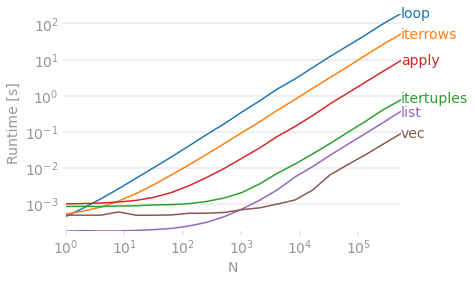

In [ ]:
kernels = [
  loop_impl,
  iterrows_impl,
  itertuples_impl,
  apply_impl,
  list_impl,
  vec_impl
]

labels = [str(k.__name__)[:-5] for k in kernels]

perfplot.show(
  setup=lambda n: test_data_sample(n),
  kernels=kernels,
  labels=labels,
  n_range=[2**k for k in range(20)],
  xlabel='N',
  logx=True,
  logy=True,
  #equality_check=None
)

## Summary

Performance Comparision:

| Method             | Time (s) |
| ------------------ | -------: | 
| Python Loop        |  37.5000 |
| iterrow()          |   9.5900 |
| apply()            |   1.7500 |
| itertuples()       |   0.1780 |
| List Comprehension |   0.0707 |
| Vectorization      |   0.0195 |